# ECE 539 Project: Analysis and Prediction of Heart Disease (Main Code)

In [1]:
# IMPORT LIBRARIES AND SET WORKING DIRECTORY

DIR = './'

'''
# To use Google Colab, uncomment this section and set DIR (above) to appropriate directory path
from google.colab import drive
drive.mount('/content/drive')
DIR = '/content/drive/...'
'''

import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix

import seaborn as sn


## Data Fetching

In [2]:
# data from https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset
# possible alternate: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction?select=heart.csv

data = pd.read_csv(os.path.join(DIR, 'heart.csv'), delimiter=',')

In [3]:
data.head(3)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0


## Data Processing

In the original data, some features consist string values. We need to convert them to numbers. In this case, we use one hot encoding to ensure unbiased analysis.

In [4]:
encoder = OneHotEncoder(handle_unknown='ignore')

Sex_df = pd.DataFrame(encoder.fit_transform(data[['Sex']]).toarray())
ChestPainType_df = pd.DataFrame(encoder.fit_transform(data[['ChestPainType']]).toarray())
RestingECG_df =  pd.DataFrame(encoder.fit_transform(data[['RestingECG']]).toarray())
ExerciseAngina_df = pd.DataFrame(encoder.fit_transform(data[['ExerciseAngina']]).toarray())
ST_Slope_df = pd.DataFrame(encoder.fit_transform(data[['ST_Slope']]).toarray())

data = pd.concat([data, Sex_df, ChestPainType_df, RestingECG_df, ExerciseAngina_df, ST_Slope_df], axis=1)
data = pd.concat([data, ChestPainType_df, ], axis=1)

data.drop('Sex', axis=1, inplace=True)
data.drop('ChestPainType', axis=1, inplace=True)
data.drop('RestingECG', axis=1, inplace=True)
data.drop('ExerciseAngina', axis=1, inplace=True)
data.drop('ST_Slope', axis=1, inplace=True)
y_data = data['HeartDisease']
data.drop('HeartDisease', axis=1, inplace=True)

In [5]:
# Get featues and labels and normalize

X = data.to_numpy()
y = y_data.to_numpy()

X = normalize(X)

In [6]:
from sklearn.decomposition import PCA

# X = PCA(n_components=15).fit_transform(X)

In [7]:
np.count_nonzero(X)

9771

In [8]:
X.shape[0]*X.shape[1]

22032

In [9]:
# Split data
# train/test/validation = 70/15/15
# Random state set to get the same results

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1, shuffle=True)

## Data Analysis

In [10]:
models = {}
models['Logistic Regression'] = LogisticRegression(max_iter=20000)
models['Support Vector Machine'] = LinearSVC(max_iter=200000)
models['Decision Tree'] = DecisionTreeClassifier()
models['Random Forest'] = RandomForestClassifier()
models['Naive Bayes'] = GaussianNB()
models['K Nearest Neighbor'] = KNeighborsClassifier()

In [11]:
accuracy, precision, recall, f1, Cmats = {}, {}, {}, {}, {}

for key in models.keys():
    
    # Fit the classifier model
    models[key].fit(X_train, y_train)
    
    # Prediction 
    predictions = models[key].predict(X_test)
    
    # Calculate Accuracy, Precision and Recall Metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test, average='micro')
    recall[key] = recall_score(predictions, y_test, average='micro')
    f1[key] = f1_score(predictions, y_test, average='micro')
    Cmats[key] = confusion_matrix(predictions, y_test)

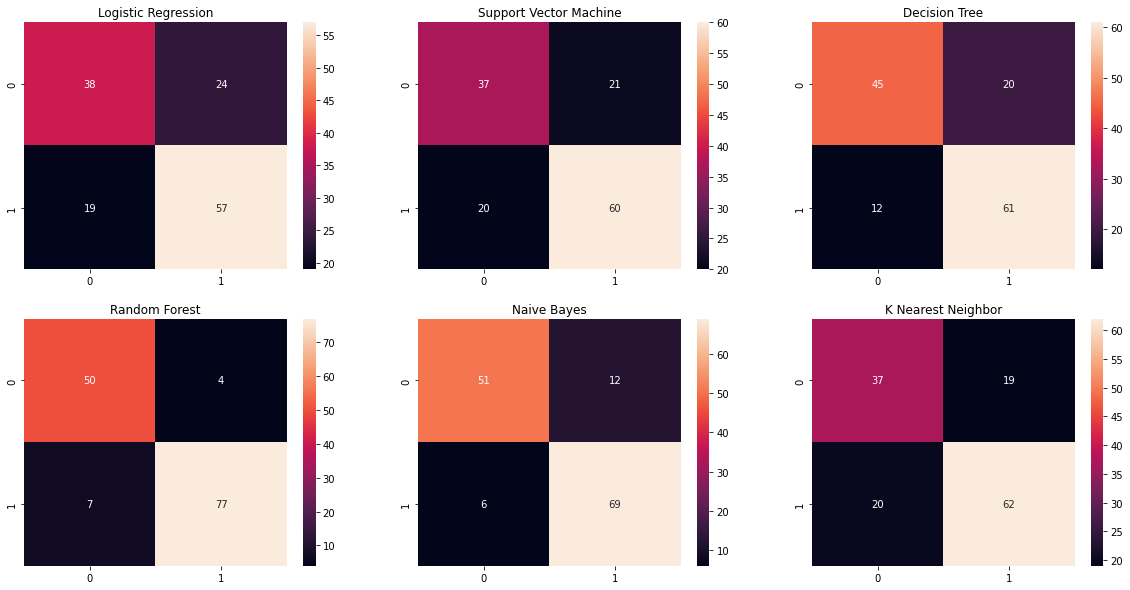

In [12]:
i = 231
fig = plt.figure(figsize=(20,10))
for key in Cmats.keys():
    cmat = Cmats[key]
    ax = fig.add_subplot(i)
    ax.title.set_text(key)
    sn.heatmap(cmat, annot=True)
    i = i + 1

In [13]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['F1 Score'] = f1.values()

df_model.sort_values(by='Accuracy',ascending=False)

,Accuracy,Precision,Recall,F1 Score
Random Forest,0.920290,0.920290,0.920290,0.920290
Naive Bayes,0.869565,0.869565,0.869565,0.869565
Decision Tree,0.768116,0.768116,0.768116,0.768116
K Nearest Neighbor,0.717391,0.717391,0.717391,0.717391
Support Vector Machine,0.702899,0.702899,0.702899,0.702899
Logistic Regression,0.688406,0.688406,0.688406,0.688406


### DNN

In [14]:
# Change labels to one hot
y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)
y_test = tf.keras.utils.to_categorical(y_test)

In [15]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_dim=X_train.shape[1], activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'),
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 7,906
Trainable params: 7,906
Non-trainable params: 0
_________________________________________________________________


2022-05-04 00:48:09.274585: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-04 00:48:09.274873: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=16)

Epoch 1/200


2022-05-04 00:48:09.484828: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


42/42 [==============================] - 1s 14ms/step - loss: 0.6851 - accuracy: 0.6392 - val_loss: 0.6379 - val_accuracy: 0.5641
Epoch 2/200
42/42 [==============================] - 0s 2ms/step - loss: 0.6467 - accuracy: 0.5693 - val_loss: 0.5900 - val_accuracy: 0.6667
Epoch 3/200
42/42 [==============================] - 0s 2ms/step - loss: 0.6337 - accuracy: 0.6359 - val_loss: 0.5694 - val_accuracy: 0.8120
Epoch 4/200
42/42 [==============================] - 0s 2ms/step - loss: 0.6046 - accuracy: 0.7243 - val_loss: 0.5464 - val_accuracy: 0.7778
Epoch 5/200
42/42 [==============================] - 0s 2ms/step - loss: 0.5969 - accuracy: 0.7009 - val_loss: 0.5180 - val_accuracy: 0.8120
Epoch 6/200
42/42 [==============================] - 0s 2ms/step - loss: 0.5910 - accuracy: 0.6940 - val_loss: 0.4921 - val_accuracy: 0.8291
Epoch 7/200
42/42 [==============================] - 0s 2ms/step - loss: 0.5542 - accuracy: 0.7456 - val_loss: 0.4559 - val_accuracy: 0.8376
Epoch 8/200
42/42 [=====

<AxesSubplot:>

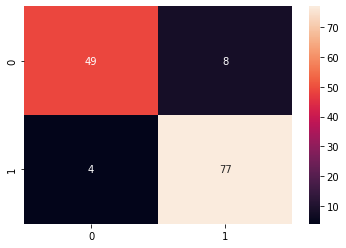

In [17]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = -1)
y_pred = tf.keras.utils.to_categorical(y_pred)
Cmat = confusion_matrix(y_test.argmax(axis=-1),y_pred.argmax(axis=-1))
sn.heatmap(Cmat, annot=True)

In [18]:
print('Accuracy: %2.2f' % ((Cmat[0,0]+Cmat[1,1])/np.sum(Cmat)*100) + '%')

Accuracy: 91.30%


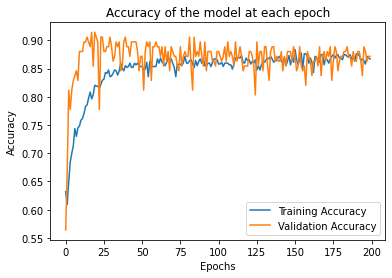

In [19]:
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy of the model at each epoch')
plt.legend(['Training Accuracy','Validation Accuracy'])